# Preprocessing

In [1]:
api_key = ""
channel_id = ""

In [2]:
from googleapiclient.discovery import build
youtube = build("youtube", "v3", developerKey=api_key)

In [3]:
def get_channel_videos(channel_id):
    res = youtube.channels().list(id=channel_id,
                                 part="contentDetails").execute()
    playlist_id = res["items"][0]["contentDetails"]["relatedPlaylists"]["uploads"]
    
    videos = []
    next_page_token = None
    
    while 1:
        res = youtube.playlistItems().list(playlistId=playlist_id,
                                          part="snippet",
                                          maxResults=50,
                                          pageToken=next_page_token).execute()
        videos += res["items"]
        next_page_token = res.get("nextPageToken")
        
        if next_page_token is None:
            break
    
    return videos

In [4]:
videos = get_channel_videos(channel_id)

In [5]:
res = youtube.videos().list(id=videos[0]["snippet"]["resourceId"]["videoId"],
                           part="statistics").execute()

In [6]:
video_ids = list(map(lambda x:x['snippet']['resourceId']['videoId'], videos))

In [7]:
def get_videos_stats(video_ids):
    stats = []
    for i in range(0, len(video_ids), 50):
        res = youtube.videos().list(id=','.join(video_ids[i:i+50]),
                                   part='statistics').execute()
        stats += res['items']
    return stats

In [8]:
stats = get_videos_stats(video_ids)

# List Before Dataframe

In [24]:
publishedAt = []
title = []
viewCount = []
likeCount = []
dislikeCount = []
commentCount = []

for i in range(len(videos)):
    publishedAt.append(videos[i]['snippet']['publishedAt'])
    title.append(videos[i]['snippet']['title'])
    viewCount.append(stats[i]['statistics']['viewCount'])
    likeCount.append(stats[i]['statistics']['likeCount'])
    dislikeCount.append(stats[i]['statistics']['dislikeCount'])
    commentCount.append(stats[i]['statistics']['commentCount'])

# Dataframe
공개일, 제목, 조회수, 좋아요수, 싫어요수, 댓글수

In [25]:
import pandas as pd
names = ['publishedAt', 'title', 'viewCount', 'likeCount', 'dislikeCount', 'commentCount']
df = pd.DataFrame(data=list(zip(publishedAt, title, viewCount, likeCount, dislikeCount, commentCount)),
                 columns=names)

# int로 변환

In [26]:
df['viewCount'] = df['viewCount'].astype(int)
df['likeCount'] = df['likeCount'].astype(int)
df['dislikeCount'] = df['dislikeCount'].astype(int)
df['commentCount'] = df['commentCount'].astype(int)

# 라이브 영상 Drop하기

In [27]:
import re
def reg_live(word):
    if re.compile('라이브').search(word):
        return True
    else:
        return False

In [28]:
df['live'] = df['title'].apply(reg_live)

In [29]:
df = df.loc[(df['live'] == False)]
len(df)

2590

# 과거 절반 데이터 Drop하기

In [30]:
df = df[:int(len(df)/2)]
len(df)

1295

# 최근 데이터 Drop하기
공개된지 몇 시간 되지 않아 아직 조회수가 채워지지 않았기 때문에 같은 기준으로 분석할 수 없다.

In [31]:
df = df[5:]
len(df)

1290

# 필요한 column 빼고 전부 Drop하기

In [32]:
df = df[['title', 'viewCount']]

# 전처리 완료

In [33]:
df.head()

,title,viewCount
6,에이치엘비 엘제인수 큰그림! 노벨상 받은 노바티스 신약 FDA승인거절,8203
7,에이치엘비 롤모델 길리어드는 효능이 좋은데 왜 FDA승인거절 받았는가?,3966
9,에이치엘비생명과학 인공지능으로 적응증 찾는다!,3856
10,에이치엘비 하락 멈춰!,8837
11,에이치엘비 진양곤 회장의 넥사인수와 엘제인수의 공통점!!,10051


# 분석

# 제목에 '에이치엘비'가 있다면 Drop하기

In [34]:
df['에이치엘비'] = df['title'].str.contains('에이치엘비')
df = df.loc[(df['에이치엘비'] == False)]
len(df)

184

# 조회수 상위 순으로 정렬하기

In [36]:
df.sort_values(by='viewCount', ascending=False)[:20]

,title,viewCount,에이치엘비
1217,대규모 유상증자를 하면 주가는 어떻게 되나요?,12919,False
367,박셀바이오 지금까지 제가 생각하고 느껴왔던 모든 것을 말씀드립니다. 새해복 많이 받...,10036,False
337,메지온 NDA재신청 '이르면 1분기 내'라는 표현이 왜 지연우려감이 된 것일까?! ...,7088,False
1111,매번 금융위기 때 등장하는 풋옵션 대박. 옵션이란 무엇일까,6627,False
1122,한미통화스와프 체결(600억 달러). 환율 1300 가는 줄 알았자너~,6226,False
1106,셀트리온 오후 3시30분 치료제 개발 간담회,6118,False
896,"SK바이오랜드, 인수에 인수를 하면 어떻게 되는 것인가? 한 다리 건너서 SK로 다...",5044,False
275,메지온 3월 26일 NDA 재제출?!,5024,False
280,Blomberg에도 한국의 공매도전쟁이 떴다?! 타임스퀘어에 광고가?!,4897,False
898,SK바이오랜드 시간외 하한가 어떻게 바라볼 것인가?,4828,False


일정에 대한 영상이 조회수 상위에 많이 있다. 
- 메지온 1분기 내
- 셀트리온 오후 3시 30분
- 메지온 3월 26일
- 셀트리온 27일 중앙약심

# 일정을 나타내는 키워드

In [37]:
import re
def reg_func(word):
    if re.compile('[0-9]+[월]|[0-9]+[일]|[0-9]+[시]|[0-9]+[분]|다음주|다음 주|다음달|다음 달|이번주|이번 주|이번달|이번 달|내일').search(word):
        return True
    else:
        return False

In [38]:
df['schedule'] = df['title'].apply(reg_func)

In [39]:
df.loc[(df['schedule'] == True)].head()

,title,viewCount,에이치엘비,schedule
275,메지온 3월 26일 NDA 재제출?!,5024,False,True
296,셀트리온 27일 오후 2시 중앙약심 렉키로나주 결정?!,2186,False,True
306,셀트리온 27일 중앙약심 자문 결과로 사실상 허가 결정?!,3510,False,True
337,메지온 NDA재신청 '이르면 1분기 내'라는 표현이 왜 지연우려감이 된 것일까?! ...,7088,False,True
359,셀트리온 13일에 임상 2상 결과 조기발표?!,1140,False,True


# 조회수 평균 구하기

In [40]:
df.groupby('schedule').viewCount.size()

schedule
False    168
True      16
Name: viewCount, dtype: int64

In [41]:
df.groupby('schedule').viewCount.mean()

schedule
False    1471.642857
True     2467.062500
Name: viewCount, dtype: float64

# t-test하기

In [42]:
from scipy.stats import ttest_ind
schedule = df.loc[df['schedule'] == True].viewCount
non_schedule = df.loc[df['schedule'] == False].viewCount

In [43]:
len(schedule)

16

In [44]:
len(non_schedule)

168

In [45]:
ttest_ind(schedule, non_schedule)

Ttest_indResult(statistic=2.2143900773848832, pvalue=0.02804360446106258)

# barchart

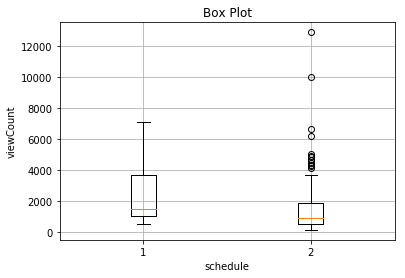

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.boxplot([schedule, non_schedule])
plt.xlabel('schedule')
plt.ylabel('viewCount')
plt.title('Box Plot')
plt.grid()
plt.show()

# Results
제목에 '에이치엘비'가 없는 영상 중에서  
'일정' 키워드가 있는 영상의 평균 조회수는 2,467회  
'일정' 키워드가 없는 영상의 평균 조회수는 1,471회  
(p=0.028)

# Conclusion
제목에 '에이치엘비'가 없으면 '일정' 키워드가 있는 영상을 업로드한다.